**II. XGBoost**

Implement XGBoost ở mức cơ bản hạn chế.

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from math import log
import pandas as pd

class XGBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 n_estimators=100,
                 learning_rate=0.1,
                 max_depth=3,
                 min_samples_leaf=1,
                 gamma=0.0, lam=1.0,
                 subsample=1.0, colsample_bytree=1.0,
                 tree_method='exact', sketch_eps=0.03):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.gamma, self.lam = gamma, lam
        self.subsample, self.colsample_bytree = subsample, colsample_bytree
        self.tree_method = tree_method
        self.sketch_eps = sketch_eps

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_samples, n_features = X.shape
        self.init_pred_ = np.mean(y)
        y_pred = np.full_like(y, self.init_pred_, dtype=float)
        self.trees_ = []

        for _ in range(self.n_estimators):
            # Row và column subsample
            idx = np.random.choice(n_samples, int(self.subsample*n_samples), replace=False)
            cols = np.random.choice(n_features, int(self.colsample_bytree*n_features), replace=False)
            X_sub = X[idx][:, cols]
            residual = y[idx] - y_pred[idx]

            bins_list = []
            if self.tree_method == 'approx':
                # xây bin mỗi vòng
                num_bins = max(2, int(1.0/self.sketch_eps))
                Xb = np.empty_like(X_sub)
                for j in range(X_sub.shape[1]):
                    col_vals = X_sub[:, j]
                    bins = np.unique(np.quantile(col_vals, np.linspace(0,1,num_bins)))
                    bins_list.append(bins)
                    # digitize
                    Xb[:, j] = np.digitize(col_vals, bins)
                X_fit = Xb
            else:
                bins_list = [None]*len(cols)
                X_fit = X_sub

            # fit tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_fit, residual)
            self.trees_.append((tree, cols, bins_list))

            # cập nhận dự đoán trên toàn tập dữ liệu
            if self.tree_method == 'approx':
                # digitize toàn bộ
                X_full_b = np.empty((n_samples, len(cols)))
                for j, col in enumerate(cols):
                    bins = bins_list[j]
                    X_full_b[:, j] = np.digitize(X[:, col], bins)
                update = tree.predict(X_full_b)
            else:
                update = tree.predict(X[:, cols])

            y_pred += self.learning_rate * update

        return self

    def predict(self, X):
        X = check_array(X)
        y_pred = np.full(X.shape[0], self.init_pred_, dtype=float)
        for tree, cols, bins_list in self.trees_:
            if self.tree_method == 'approx':
                Xb = np.empty((X.shape[0], len(cols)))
                for j, col in enumerate(cols):
                    bins = bins_list[j]
                    Xb[:, j] = np.digitize(X[:, col], bins)
                upd = tree.predict(Xb)
            else:
                upd = tree.predict(X[:, cols])
            y_pred += self.learning_rate * upd
        return y_pred


class XGBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 n_estimators=100,
                 learning_rate=0.1,
                 max_depth=3,
                 min_samples_leaf=1,
                 gamma=0.0, lam=1.0,
                 subsample=1.0, colsample_bytree=1.0,
                 tree_method='exact', sketch_eps=0.03):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.gamma, self.lam = gamma, lam
        self.subsample, self.colsample_bytree = subsample, colsample_bytree
        self.tree_method = tree_method
        self.sketch_eps = sketch_eps

    def _sigmoid(self, x):
        return 1.0/(1.0+np.exp(-x))

    def fit(self, X, y):
        X, y = check_X_y(X, y, dtype=float)
        # log-odds
        p = np.clip(y.mean(), 1e-6, 1-1e-6)
        self.init_pred_ = log(p/(1-p))
        raw = np.full_like(y, self.init_pred_, dtype=float)
        n_samples, n_features = X.shape
        self.trees_ = []

        for _ in range(self.n_estimators):
            idx = np.random.choice(n_samples, int(self.subsample*n_samples), replace=False)
            cols = np.random.choice(n_features, int(self.colsample_bytree*n_features), replace=False)
            X_sub = X[idx][:, cols]
            p_pred = self._sigmoid(raw[idx])
            grad = y[idx] - p_pred

            bins_list = []
            if self.tree_method == 'approx':
                num_bins = max(2, int(1.0/self.sketch_eps))
                Xb = np.empty_like(X_sub)
                for j in range(X_sub.shape[1]):
                    vals = X_sub[:, j]
                    bins = np.unique(np.quantile(vals, np.linspace(0,1,num_bins)))
                    bins_list.append(bins)
                    Xb[:, j] = np.digitize(vals, bins)
                X_fit = Xb
            else:
                bins_list = [None]*len(cols)
                X_fit = X_sub

            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         min_samples_leaf=self.min_samples_leaf)
            tree.fit(X_fit, grad)
            self.trees_.append((tree, cols, bins_list))

            if self.tree_method == 'approx':
                Xfb = np.empty((n_samples, len(cols)))
                for j, col in enumerate(cols):
                    Xfb[:, j] = np.digitize(X[:, col], bins_list[j])
                upd = tree.predict(Xfb)
            else:
                upd = tree.predict(X[:, cols])

            raw += self.learning_rate * upd

        return self

    def predict_proba(self, X):
        X = check_array(X)
        raw = np.full(X.shape[0], self.init_pred_, dtype=float)
        for tree, cols, bins_list in self.trees_:
            if self.tree_method == 'approx':
                Xb = np.empty((X.shape[0], len(cols)))
                for j, col in enumerate(cols):
                    Xb[:, j] = np.digitize(X[:, col], bins_list[j])
                upd = tree.predict(Xb)
            else:
                upd = tree.predict(X[:, cols])
            raw += self.learning_rate * upd
        p = self._sigmoid(raw)
        return np.vstack([1-p, p]).T

    def predict(self, X):
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)

**II.1 Dự đoán giá xe cũ (bài toán hồi quy)**


In [2]:
import re
import pandas as pd
def pre_processing(data):
    categorical_cols = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
    mappings = {}

    for col in categorical_cols:
        data[col] = data[col].fillna('Unknown').astype(str)
        unique_vals = sorted(data[col].unique())
        mappings[col] = {val: idx for idx, val in enumerate(unique_vals)}
        data[col] = data[col].map(mappings[col])

    special_cols = ['Max Power', 'Max Torque']
    for col in special_cols:
        data[col] = data[col].apply(lambda x: re.findall(r'^\d+\.?\d*', str(x))[0] if pd.notna(x) and re.findall(r'^\d+\.?\d*', str(x)) else '0')
        data[col] = data[col].astype(float)

    numerical_cols = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
    for col in numerical_cols:
        data[col] = data[col].astype(float)
    #xử lí các cột Engine, age (=2024 - Year),seating Capacity và fuel tank capacity
    data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].mean(), inplace=True)
    data['Engine'] = data['Engine'].str.split(' ', expand = True)[0].astype(float)
    data['Engine'].fillna(data['Engine'].mean(), inplace=True)
    data['age'] = 2024 - data['Year']
    data['Seating Capacity'].bfill(inplace=True)
    #Xử lí cột Make-Num (bằng `xếp hạng` thứ tự giá trung bình các `hãng xe` rồi gán cho từng cột tương ứng với các hãng)
    #print(data['Make'])
    make_rank = data[['Make', 'Price']].groupby('Make').mean().rank()
    data['Make-Num'] = data['Make'].map(make_rank['Price'])
    data['Make-Num']
    #print(make_rank)
    # data['Make-Num'] = 0
    # for make in make_rank['Make']:
    #     data.loc[data['Make'] == make,'Make-Num'] = make_rank.loc[make]
    # data.info()
data = pd.read_csv("train.csv")
print(data.head())
pre_processing(data)

            Make                            Model     Price  Year  Kilometer  \
0            BMW                    3-Series 320d    800000  2012      75576   
1            BMW               X1 sDrive20d xLine   2199000  2016      77000   
2       Mahindra                   XUV500 W4 1.99    800000  2017     112000   
3  Mercedes-Benz                  GLS 400d 4MATIC  12900000  2021       3000   
4         Toyota  Fortuner 2.8 4x2 AT [2016-2020]   3499000  2019      73000   

  Fuel Type Transmission     Location   Color   Owner Seller Type   Engine  \
0    Diesel    Automatic       Mumbai   White  Second  Individual      NaN   
1    Diesel    Automatic        Surat   Black   First  Individual  1995 cc   
2    Diesel       Manual  Muzaffurpur  Silver   First  Individual  1997 cc   
3    Diesel    Automatic        Delhi   White   First  Individual  2925 cc   
4    Diesel    Automatic       Mumbai   White   First  Individual  2755 cc   

            Max Power         Max Torque Drivetrai

C:\Users\Admin\AppData\Local\Temp\ipykernel_24772\3245499715.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fuel Tank Capacity'].fillna(data['Fuel Tank Capacity'].mean(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24772\3245499715.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

--- Đánh giá mô hình (tập train) ---

Mean Squared Error (MSE): 20900082861.36
Coefficient of Determination (R²): 0.996


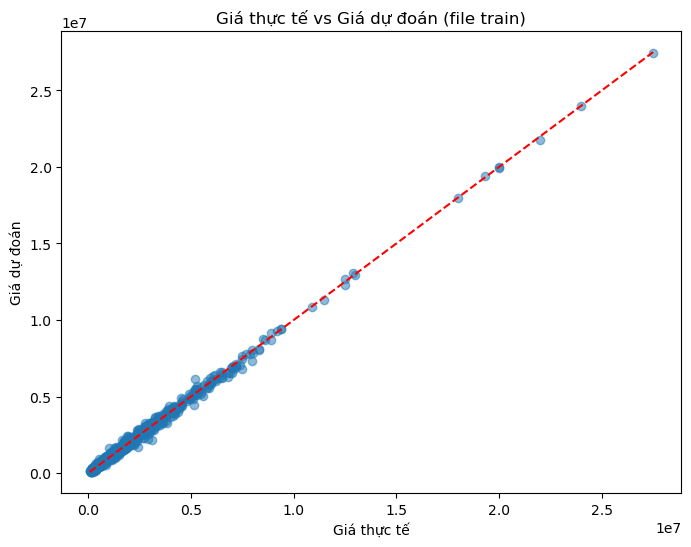

--- Đánh giá mô hình (tập test) ---

Mean Squared Error (MSE): 555608047615.82
Coefficient of Determination (R²): 0.885


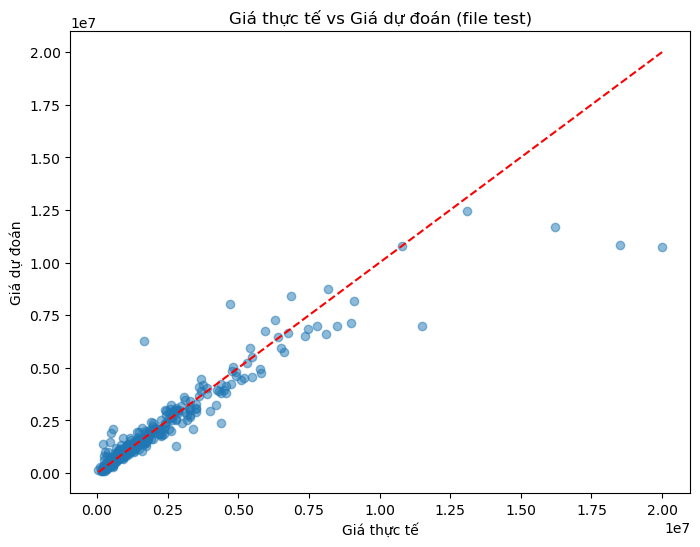

In [3]:
from sklearn.model_selection import train_test_split
y = data['Price'].fillna(0)
X = data.drop('Price', axis=1)
X = X.replace([np.inf, -np.inf], 0).fillna(0)
# Loại cột có tương quan cao (> 0.9)
correlation_matrix = X.corr()
high_corr = set()
corr_threshold = 0.9
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)
if len(high_corr) > 0:
    X = X.drop(columns=high_corr)
#huấn luyện mô hình
XGB_regression = XGBoostRegressor(n_estimators=300, tree_method="exact")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
XGB_regression.fit(X_train, y_train)
#dự đoán (file train)
y_pred = XGB_regression.predict(X_train)
y_vec = y_train.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập train) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file train)')
plt.show()
#dự đoán (file test)
y_pred = XGB_regression.predict(X_test)
y_vec = y_test.values
mse = np.mean((y_vec - y_pred) ** 2)
rss = np.sum((y_vec - y_pred) ** 2)  # Residual Sum of Squares
tss = np.sum((y_vec - np.mean(y_vec)) ** 2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)
print("--- Đánh giá mô hình (tập test) ---")
print(f"\nMean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r_squared:.3f}")
actual_prices = y_vec
predicted_prices = y_pred
min_val = min(np.min(actual_prices), np.min(predicted_prices))
max_val = max(np.max(actual_prices), np.max(predicted_prices))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Vẽ đường y = x
plt.xlabel('Giá thực tế')
plt.ylabel('Giá dự đoán')
plt.title('Giá thực tế vs Giá dự đoán (file test)')
plt.show()

**II.2 Dự đoán ung thư hay không (bài toán phân loại)**

In [4]:
data = 'ABIDE2(updated).csv'

df = pd.read_csv(data)
df['num'] = (df['group'] == 'Cancer').astype(int)
X = df.drop(['site', 'age', 'group', 'num'], axis=1)

y = df['num']
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chuẩn hóa dữ liệu
X_std = StandardScaler().fit_transform(X)

# Khởi tạo và fit mô hình PCA của scikit-learn
sklearn_pca = PCA(n_components=190)
sklearn_pca.fit(X_std)
X_sklearn = sklearn_pca.transform(X_std)
X_sklearn.shape

(1004, 190)

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X_sklearn, y, test_size = 0.3, random_state = 0)
XGB_class = XGBoostClassifier(tree_method="exact",max_depth=3, min_samples_leaf = 5, learning_rate=0.05, n_estimators=300)
XGB_class.fit(X_train, y_train)

XGBoostClassifier(learning_rate=0.05, min_samples_leaf=5, n_estimators=300)

In [6]:
y_pred = XGB_class.predict(X_train)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Train file: ')
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_train, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_train, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_train, y_pred)))

Train file: 
XGBoost model accuracy score: 0.9530
XGBoost model precision score: 0.9965
XGBoost model recall score: 0.8994
XGBoost model f1-score score: 0.9455


In [8]:
y_pred = XGB_class.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('Validation file: ')
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('XGBoost model precision score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('XGBoost model recall score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('XGBoost model f1-score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

Validation file: 
XGBoost model accuracy score: 0.5927
XGBoost model precision score: 0.6122
XGBoost model recall score: 0.4138
XGBoost model f1-score score: 0.4938
